# ASMSA: Train AAE model with the tuned hyperparameters

**Previous steps**
- [prepare.ipynb](prepare.ipynb): Download and sanity check input files
- [tune.ipynb](tune.ipynb): Perform initial hyperparameter tuning for this molecule

**Next step**
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

## Notebook setup

In [ ]:
#%cd villin

In [1]:
threads = 2
import os
os.environ['OMP_NUM_THREADS']=str(threads)
import tensorflow as tf

# PyTorch favours OMP_NUM_THREADS in environment
import torch

# Tensorflow needs explicit cofig calls
tf.config.threading.set_inter_op_parallelism_threads(threads)
tf.config.threading.set_intra_op_parallelism_threads(threads)

2025-04-14 20:27:22.884402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-14 20:27:22.907823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-14 20:27:22.914876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 20:27:22.932249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 20:27:23.978223: W tensorflow/compiler/tf2

In [2]:
from asmsa.tuning_analyzer import TuningAnalyzer
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import urllib.request
from tensorflow import keras
import keras_tuner
import asmsa.visualizer as visualizer
import asmsa


from asmsa.plot_training import LiveTrainingPlot

2025-04-14 20:27:26.575298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1206 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0


## Input files

All input files are prepared (up- or downloaded) in [prepare.ipynb](prepare.ipynb). 


In [3]:
exec(open('inputs.py').read())

In [4]:
#exec(open('inputs-des.py').read())

## Apply the tuning results

In [5]:
# pick from plots in tune.ipynb

best_enc_seed=128
best_disc_seed=32

In [6]:
# Get best HP from latest tuning
analyzer = TuningAnalyzer()
analyzer.get_best_hp(num_trials=3)

Analyzing tuning from: /home/jovyan/ASMSA/analysis/09152024-062740/
Printing results of tuning: /home/jovyan/ASMSA/analysis/09152024-062740/
-----(1)-----
Trial ID: af0a1be1bc6e6b34943556cfaaf5329e63d7a224f8e4aa892d62b941673839f3
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.15383518146453173
-----(2)-----
Trial ID: abae5f92717a95f68c7f7560850cef4a5fd75cd6ff0b0639ce6bb8324bf15efa
Hyperparameters:
activation: selu
ae_number_of_layers: 2
disc_number_of_layers: 2
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.18225192744528268
-----(3)-----
Trial ID: b2c0e33e1bc5ab4528251267d0f562aaabc06e4e25a736d0da8e0167833e1feb
Hyperparameters:
activation: selu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 512
optimizer: Adam
learning_rate: 0.0002
ae_loss_

In [7]:
# Select HP to use by specifying trial_id
#  e.g: trial_id = '483883b929b3445bff6dee9759c4d50ee3a4ba7f0db22e665c49b5f942d9693b'
# ... or don't specify, by default use the trial with the lowest score
trial_id = 'abae5f92717a95f68c7f7560850cef4a5fd75cd6ff0b0639ce6bb8324bf15efa'

hps = None
for trial in analyzer.sorted_trials:
    if trial['trial_id'] == trial_id:
        hps = trial['hp']
    
if not hps:
    print(f'Could not find trial with specified ID, using one with the lowest score - {analyzer.sorted_trials[0]["trial_id"]}')
    hps = analyzer.sorted_trials[0]['hp']
    
print(hps)

{'activation': 'selu', 'ae_number_of_layers': 2, 'disc_number_of_layers': 2, 'batch_size': 64, 'optimizer': 'Adam', 'learning_rate': 0.0002, 'ae_loss_fn': 'MeanSquaredError', 'disc_loss_fn': 'BinaryCrossentropy'}


## Load datasets
Load filtered trajectory datasets that were processed in **prepare.ipynb**. Trajectories are in internal coordinates format.

In [8]:
# load train dataset
X_train = tf.data.Dataset.load('../ASMSA.final/datasets/intcoords/train')

# get batched version of dataset to feed to AAE model for training
X_train_batched = X_train.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for visualization purposes
X_train_np = np.stack(list(X_train))
X_train_np.shape

2025-04-14 20:27:35.413787: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(34599, 1355)

In [9]:
# load test dataset
X_test = tf.data.Dataset.load('../ASMSA.final/datasets/intcoords/test')

# get batched version of dataset to feed to AAE model for prediction
X_test_batched = X_test.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for testing purposes
X_test_np = np.stack(list(X_test))
X_test_np.shape

2025-04-14 20:28:09.647326: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(7444, 1355)

In [11]:
X_val = tf.data.Dataset.load('../ASMSA.final/datasets/intcoords/validate').batch(hps['batch_size'],drop_remainder=True)
X_val_np = np.stack(list(X_val))
X_val_np.shape

2025-04-14 20:28:19.285416: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(117, 64, 1355)

## Train

### Distribution prior
Train with common prior distributions. See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions for all available distributions. It is ideal to use tuned Hyperparameters for training.

In [12]:
# set used prior

# this one is (more or less) required to with the density alignment
# prior = tfp.distributions.MultivariateNormalDiag(loc=[0.,0.])

prior = tfp.distributions.Normal(loc=0, scale=1)
# prior = tfp.distributions.Uniform()
# prior = tfp.distributions.Weibull(1,0.5)
# prior = tfp.distributions.Cauchy(loc=0, scale=1)

In [13]:
# prepare model using the best hyperparameters
testm = asmsa.AAEModel((X_train_np.shape[1],),
                       prior=prior,
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       with_density=False
                      )
testm.compile()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
testm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1355)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_0 (Dense)                   │ (None, 128)            │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_1 (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_2 (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_2 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_out (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_3 (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_3 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_1 (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_0 (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_out (Dense)                 │ (None, 1355)           │       174,795 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1355)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,085 (1.42 MB)

 Trainable params: 370,189 (1.41 MB)

 Non-trainable params: 896 (3.50 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_0 (Dense)                  │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_0 (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_1 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_1 (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_2 (Dense)                  │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_2 (LeakyReLU)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_out (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# specify earlystopping callback to avoid overfitting
#monitored_metric = "val_AE loss min"
#monitored_metric = 'val_loss'

metric_groups = {
    'Autoencoder Loss': ['AE loss min', 'val_val_AE loss min'],
    'Discriminator Loss': ['disc loss min', 'val_val_disc loss min']
}

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_val_AE loss min",
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

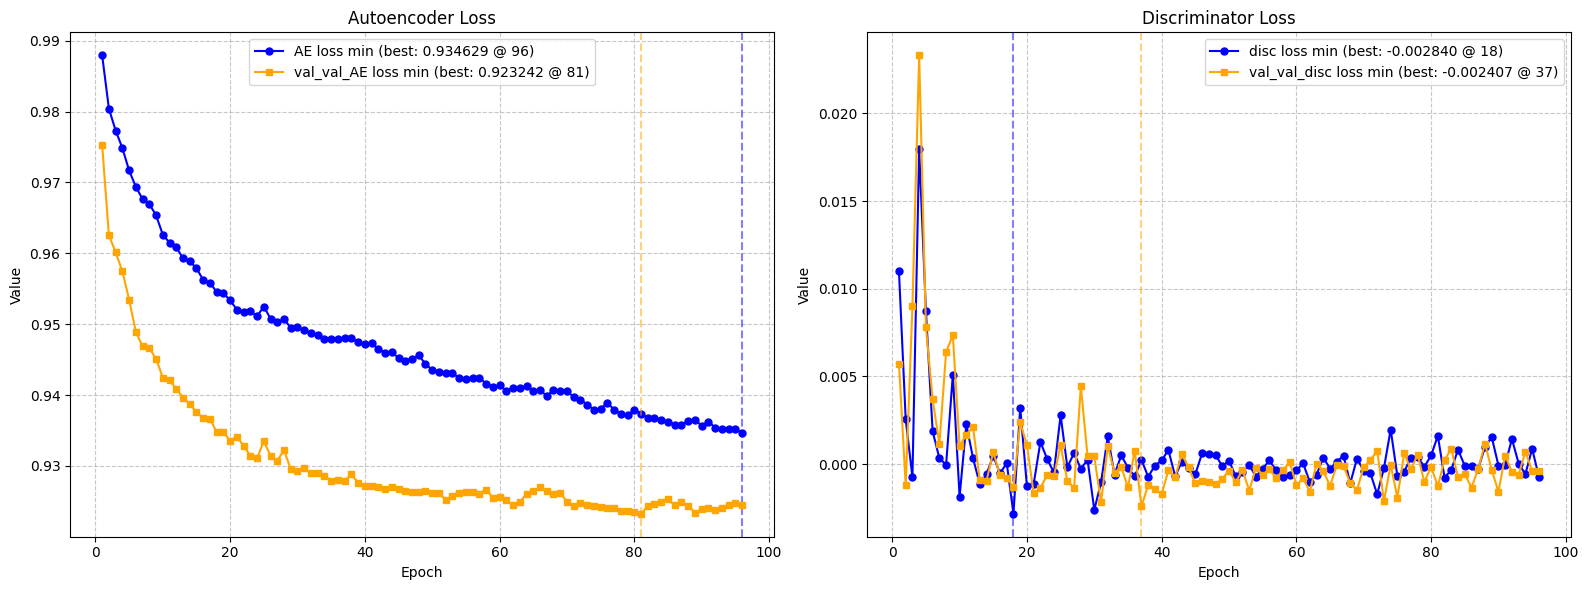

540/540 - 1s - 2ms/step - AE loss min: 0.9346 - disc loss min: -7.1385e-04 - val_val_AE loss min: 0.9244 - val_val_disc loss min: -3.7114e-04
Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 81.


In [16]:
# train it (can be repeated several times to add more epochs)

metric_groups = {
    'Autoencoder Loss': ['AE loss min', 'val_val_AE loss min'],
    'Discriminator Loss': ['disc loss min', 'val_val_disc loss min']
}

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_val_AE loss min",
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

testm.fit(X_train_batched, # X_train_dens, # X_train_batched,
          epochs=1000,
          verbose=2, # this flag is essential due to connection with EarlyStopping callback (epoch vs batch)
          validation_data=X_val,
          callbacks=[
              early_stop_cb,
              LiveTrainingPlot(metric_groups=metric_groups, freq=1),
              #visualizer.VisualizeCallback(testm,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

In [17]:
# whatever test
''' 
batch_size = 256

val_result = testm.predict(X_test_batched)
mse = keras.losses.MeanSquaredError()
dataset_size = X_test_np.shape[0]
print(dataset_size)
mse_result=[]
for i in range(0, dataset_size, batch_size):
    if i+batch_size > dataset_size:
        batch_size = batch_size-(i+batch_size-dataset_size)
    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()
    mse_result.append(batch_mse)

mse_result'''

' \nbatch_size = 256\n\nval_result = testm.predict(X_test_batched)\nmse = keras.losses.MeanSquaredError()\ndataset_size = X_test_np.shape[0]\nprint(dataset_size)\nmse_result=[]\nfor i in range(0, dataset_size, batch_size):\n    if i+batch_size > dataset_size:\n        batch_size = batch_size-(i+batch_size-dataset_size)\n    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()\n    mse_result.append(batch_mse)\n\nmse_result'

/opt/conda/lib/python3.10/site-packages/asmsa/visualizer.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0][0].scatter(x, y, s=0.1, cmap=self.cmap)


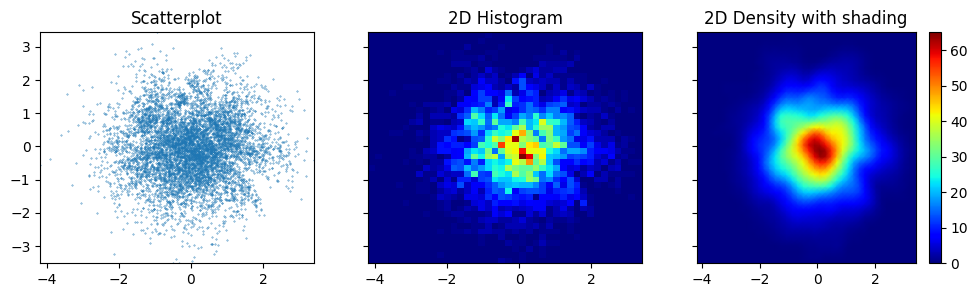

In [18]:
# final visualization, pick a slice of the input data for demo purposes
#visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np[15000:20000]).numpy())

# on test data
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_test_np).numpy())

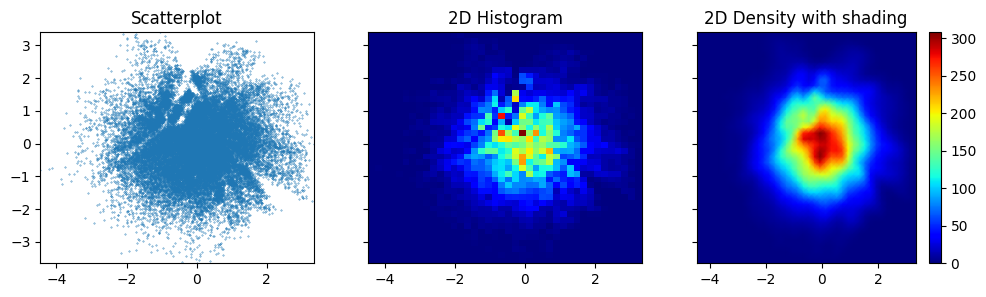

In [19]:
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np).numpy())

In [20]:
# load testing trajectory for further visualizations and computations
tr = md.load('../ASMSA.final/x_train.xtc',top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like Ala-Ala, where superposing on CAs fails
#idx=tr[0].top.select("element != H") 

tr.superpose(tr[0],atom_indices=idx)

# reshuffle the geometry to get frame last so that we can use vectorized calculations
geom = np.moveaxis(tr.xyz ,0,-1)
geom.shape

(144, 3, 34599)

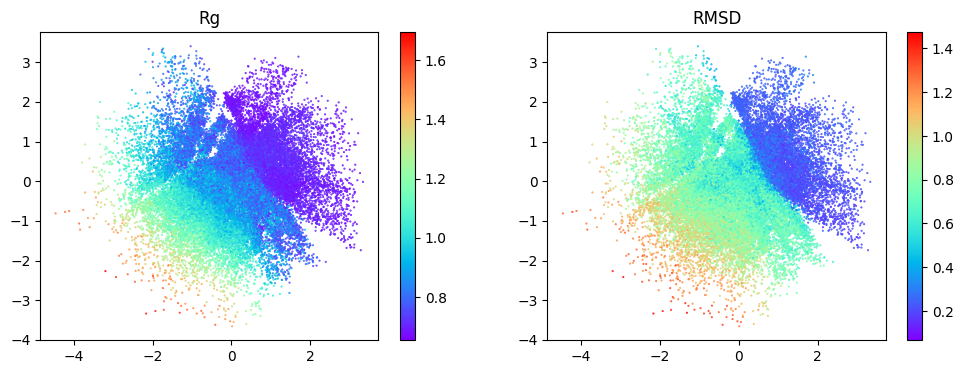

In [21]:
# Rgyr and rmsd color coded in low dim (rough view)

lows = testm.call_enc(X_train_np).numpy()
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

In [22]:
# not used
'''testm.enc.save('enc.keras')
testm.dec.save('dec.keras')
testm.disc.save('dec.keras')'''

"testm.enc.save('enc.keras')\ntestm.dec.save('dec.keras')\ntestm.disc.save('dec.keras')"

### Image prior

**Almost surely broken now with the density alignment**

Use Image as a prior distribution. Again use tuned Hyperparameters for better training performance.

In [ ]:
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1I2WP92MMWS5s5vin_4cvmruuV-1W77Hl", "mushroom_bw.png")

In [ ]:
mmush = asmsa.AAEModel((X_train_np.shape[1],),
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       prior='mushroom_bw.png'
                      )
mmush.compile()

In [ ]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_val_AE loss min",
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [ ]:
mmush.fit(X_train_batched, # X_train_dens, # X_train_batched,
          epochs=1000,
          verbose=2, # this flag is essential due to connection with EarlyStopping callback (epoch vs batch)
          validation_data=X_val,
          callbacks=[
              early_stop_cb,
              LiveTrainingPlot(metric_groups=metric_groups, freq=1),
              #visualizer.VisualizeCallback(testm,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

In [ ]:
step=4
tr2 = tr[::step]
lows = mmush.call_enc(X_test_np[::step]).numpy()
rg = md.compute_rg(tr2)
base = md.load(conf)
rmsd = md.rmsd(tr2,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

## Save the encoder and decoder models

In [23]:
import tf2onnx
import onnx2torch
import tempfile

def _convert_to_onnx(model, destination_path):
#    model = keras.models.load_model(source_path)

    input_tensor = model.layers[0]._input_tensor
#    input_tensor = model.inputs[0]
    input_signature = tf.TensorSpec(
        name=input_tensor.name, shape=input_tensor.shape, dtype=input_tensor.dtype
    )
    output_name = model.layers[-1].name

    @tf.function(input_signature=[input_signature])
    def _wrapped_model(input_data):
        return {output_name: model(input_data)}

    tf2onnx.convert.from_function(
        _wrapped_model, input_signature=[input_signature], output_path=destination_path
    )

In [24]:
model = testm

In [25]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.enc,onnx.name)
    torch_enc = onnx2torch.convert(onnx.name)

example_input = torch.randn([X_train_np.shape[1]])
traced_script_module = torch.jit.trace(torch_enc, example_input)

traced_script_module.save('encoder_therma-unf.pt')

I0000 00:00:1744662704.438551 1556495 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-14 20:31:44.439037: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-14 20:31:44.444617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1206 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
2025-04-14 20:31:44.519207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1206 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
I0000 00:00:1744662704.527000 1556495 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-14 20:31:44.527140: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting ne

In [26]:
example_input.shape

torch.Size([1355])

In [ ]:
model.enc.summary()

In [27]:
lenc = torch.jit.load('encoder_therma-unf.pt')
example_input = np.random.rand(10000,X_train_np.shape[1])
rtf = model.enc(example_input)
rpt = lenc(torch.tensor(example_input,dtype=torch.float32))

In [28]:
maxerr = np.max(np.abs(rtf - rpt.detach().numpy()))
maxerr

0.0007812381

In [29]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.dec,onnx.name)
    torch_dec = onnx2torch.convert(onnx.name)

example_input = torch.randn([2])
traced_script_module = torch.jit.trace(torch_dec, example_input)

traced_script_module.save('decoder_therma-unf.pt')

I0000 00:00:1744662717.985840 1556495 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-14 20:31:57.986071: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-14 20:31:57.991714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1206 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
2025-04-14 20:31:58.056273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1206 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0
I0000 00:00:1744662718.063617 1556495 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-14 20:31:58.063743: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting ne

In [30]:
ldec = torch.jit.load('decoder_therma-unf.pt')
example_input = np.random.rand(10000,2)
rtf = model.dec(example_input)
rpt = ldec(torch.tensor(example_input,dtype=torch.float32))

In [31]:
err = np.abs(rtf - rpt.detach().numpy())
train_mean = np.loadtxt('../ASMSA.final/datasets/intcoords/mean.txt',dtype=np.float32).reshape(1,1,-1)
rerr = err/np.abs(train_mean)
np.max(err),np.max(rerr)

(0.01321319, 49.61529)

# Vis

In [32]:
exec(open('inputs.py').read())

In [34]:
mol_model = torch.jit.load('features-thermal-unfolding.pt')
torch_encoder = torch.jit.load('encoder_therma-unf.pt')

In [35]:
test_geom = np.moveaxis(np.stack(list(tf.data.Dataset.load('../ASMSA.final/datasets/geoms/test'))),2,0)
test_geom.shape

(7444, 144, 3)

In [37]:
tr = md.load('../ASMSA.final/trpcage_ds_nH.xtc', top='../ASMSA.final/trpcage_npt400_nH.pdb')
tr.xyz.shape

(50001, 144, 3)

In [ ]:
des = md.load('../DE-Shaw/trpcage_red.xtc', top='../DE-Shaw/trpcage_correct.pdb')
des.xyz.shape

In [38]:
train_mean = np.loadtxt('../ASMSA.final/datasets/intcoords/mean.txt',dtype=np.float32)
train_scale = np.loadtxt('../ASMSA.final/datasets/intcoords/scale.txt',dtype=np.float32)

In [39]:
class CompleteModel(torch.nn.Module):
    def __init__(self, mol_model, torch_encoder, train_mean, train_scale):
        super(CompleteModel, self).__init__()
        self.mol_model = mol_model
        self.torch_encoder = torch_encoder
        # Convert train_mean and train_scale from numpy to torch tensors
        self.train_mean = torch.from_numpy(np.reshape(train_mean, (-1, 1)))
        self.train_scale = torch.from_numpy(np.reshape(train_scale, (-1, 1)))

    def forward(self, x):
        mol_output = self.mol_model(x.moveaxis(0,-1))
        normalized = (mol_output - self.train_mean) / self.train_scale
#        reshaped = normalized.reshape(-1)
        return self.torch_encoder(normalized.T)

# Initialize the CompleteModel class with your components
complete_model = CompleteModel(mol_model, torch_encoder, train_mean, train_scale)

# Save the Torch model using TorchScript trace
example_input = torch.randn([1,test_geom.shape[1], test_geom.shape[2]])
traced_script_module = torch.jit.trace(complete_model, example_input)

model_file_name = "model_thermal-unf.pt"
traced_script_module.save(model_file_name)

In [45]:
m = torch.jit.load('model_thermal-unf.pt')
lows = m(torch.tensor(tr.xyz)).numpy()
np.savetxt("lows_thermal_unfolding.txt", lows)
lows.shape

(50001, 2)

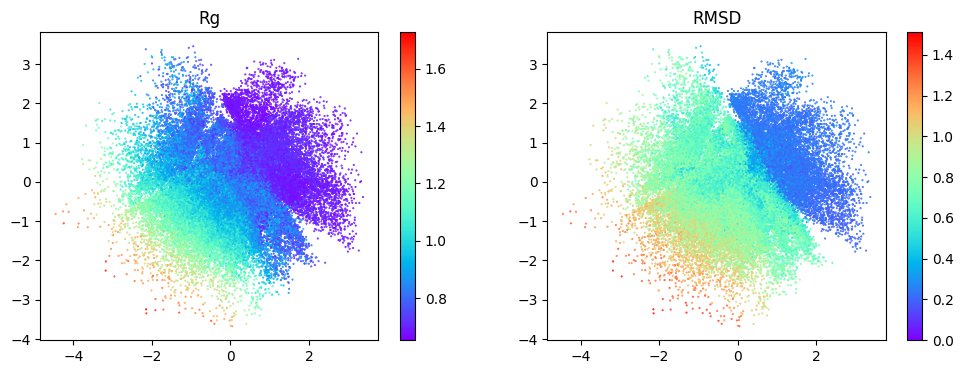

In [43]:
# visual check, should be the same as in train.ipynb
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.savefig("Thermal-unfolding.png")


# Plumed

In [46]:
grid_margin = 3.  # that many times the actual computed size added on both sides

lmin = np.min(lows,axis=0)
lmax = np.max(lows,axis=0)
llen = lmax-lmin
lmin -= llen * grid_margin
lmax += llen * grid_margin

lmin, lmax

(array([-27.937836, -25.057047], dtype=float32),
 array([26.86098 , 24.830627], dtype=float32))

In [47]:
# Atom numbering magic with Gromacs, see above

grotr = md.load(gro)
nhs = grotr.topology.select('element != H')

with open(index) as f:
    f.readline()
    ndx = np.fromstring(" ".join(f),dtype=np.int32,sep=' ')-1

pdb2gmx = nhs[np.argsort(ndx)]+1

# maybe double check manually wrt. the files
pdb2gmx

array([  1,   5,   7,  10,  11,  12,  13,  14,  15,  17,  19,  23,  24,
        25,  27,  29,  32,  33,  35,  37,  38,  40,  42,  44,  45,  46,
        48,  50,  54,  55,  56,  58,  60,  63,  66,  67,  68,  71,  72,
        73,  75,  77,  80,  81,  83,  85,  86,  88,  90,  92,  94,  95,
        96,  97,  99, 101, 104, 106, 110, 114, 115, 116, 118, 120, 124,
       125, 126, 128, 130, 133, 134, 135, 136, 137, 138, 140, 143, 144,
       145, 147, 150, 151, 152, 153, 156, 159, 162, 164, 165, 166, 168,
       170, 173, 175, 176, 177, 179, 181, 184, 186, 187, 188, 190, 193,
       194, 195, 197, 199, 202, 205, 208, 210, 211, 214, 217, 218, 219,
       220, 223, 226, 229, 231, 232, 233, 234, 237, 240, 243, 245, 246,
       247, 248, 251, 254, 257, 259, 260, 261, 263, 265, 268, 270, 272,
       271])

In [48]:
with open("plumed.dat","w") as p:
    p.write(f"""\
RESTART
WHOLEMOLECULES ENTITY0=1-{grotr.xyz.shape[1]}
model: PYTORCH_MODEL_CV FILE={model_file_name} ATOMS={','.join(map(str,pdb2gmx))}
metad: METAD ARG=model.node-0,model.node-1 PACE=1000 HEIGHT=1 BIASFACTOR=15 SIGMA=0.1,0.1 GRID_MIN={lmin[0]},{lmin[1]} GRID_MAX={lmax[0]},{lmax[1]} FILE=HILLS
PRINT FILE=COLVAR ARG=model.node-0,model.node-1,metad.bias STRIDE=100
""")